In [1]:
import glob
import numpy as np
import pandas as pd
import scipy.io
import os
import time
import cv2
import sys
import random
import collections
import matplotlib.pyplot as plt
from scipy.spatial import distance
from skimage import transform
from skimage.feature import register_translation
from sklearn.cluster import DBSCAN
from deepcell_spots.applications import SpotDetection
from deepcell_spots.spot_em import define_edges
from deepcell_spots.point_metrics import *
from deepcell_spots.singleplex import *
from deepcell_spots.multiplex import *
from deepcell_spots.image_alignment import *
from deepcell.applications import CytoplasmSegmentation
import tensorflow as tf
from deepcell_toolbox.processing import histogram_normalization,normalize
from deepcell_toolbox.deep_watershed import deep_watershed

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Import data

We can define the directory that contains all of the data and information for the experiment, including the image set, the codebook, and a .csv file describing the organization of the data.

In [3]:
from tensorflow.keras.utils import get_file
from deepcell.datasets import Dataset

def load_csv(self, path=None, test_size=0.2, seed=0):
    path = path if path else self.path
    
    basepath = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
    prefix = path.split(os.path.sep)[:-1]
    data_dir = os.path.join(basepath, *prefix) if prefix else basepath
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    elif not os.path.isdir(data_dir):
        raise IOError('{} exists but is not a directory'.format(data_dir))

    path = get_file(path,
                    origin=self.url,
                    file_hash=self.file_hash)
    
    data = pd.read_csv(path)
    
    return(data)

In [4]:
Dataset.load_data = load_csv

codebook_files = Dataset(
    path='codebook-example.csv',
    url='https://deepcell-data.s3.us-west-1.amazonaws.com/spot_detection/multiplex/codebook-example.csv',
    file_hash='81eacbc9558b7e1b5dfbeb9cb34b1a59',
    metadata={})
dataorg_files = Dataset(
    path='dataorg-example.csv',
    url='https://deepcell-data.s3.us-west-1.amazonaws.com/spot_detection/multiplex/dataorg-example.csv',
    file_hash='691ec7efcd31c37aedf1253b5e8d7cdc',
    metadata={})

codebook = codebook_files.load_data()
dataorg = dataorg_files.load_data()

In [5]:
codebook.head()

,name,Spots 1,Spots 2,Spots 3,Spots 4,Spots 5,Spots 6,Spots 7,Spots 8,Spots 10,Spots 11
0,Gabbr1,1,1,0,0,0,1,0,0,0,1
1,Gabbr2,0,0,0,1,1,1,0,0,0,1
2,Tmem119,1,0,1,0,1,0,0,1,0,0
3,Gpr34,0,0,1,1,1,0,0,0,1,0
4,Fcrls,0,0,0,1,1,0,1,1,0,0


In [6]:
dataorg

,readoutName,fileName,imagingRound,color,frame,zPos
0,Spots 1,hal-config-749z7-638z7-546z7-477z9-405z7_00.npy,-1,546,"[14, 15, 16, 17, 18, 19, 20]","[1.5, 3.0, 4.5, 6.0, 7.5, 9.0, 10.5]"
1,Spots 2,hal-config-749z7-638z7-546z7-477z9-405z7_00.npy,-1,638,"[7, 8, 9, 10, 11, 12, 13]","[10.5, 9.0, 7.5, 6.0, 4.5, 3.0, 1.5]"
2,Spots 3,hal-config-749z7-638z7-546z7-477z9-405z7_00.npy,-1,749,"[0, 1, 2, 3, 4, 5, 6]","[1.5, 3.0, 4.5, 6.0, 7.5, 9.0, 10.5]"
3,Spots 4,hal-config-749z7-638z7-546z7-477z9-405z7_00_0.npy,0,546,"[14, 15, 16, 17, 18, 19, 20]","[1.5, 3.0, 4.5, 6.0, 7.5, 9.0, 10.5]"
4,Spots 5,hal-config-749z7-638z7-546z7-477z9-405z7_00_0.npy,0,638,"[7, 8, 9, 10, 11, 12, 13]","[10.5, 9.0, 7.5, 6.0, 4.5, 3.0, 1.5]"
5,Spots 6,hal-config-749z7-638z7-546z7-477z9-405z7_00_0.npy,0,749,"[0, 1, 2, 3, 4, 5, 6]","[1.5, 3.0, 4.5, 6.0, 7.5, 9.0, 10.5]"
6,Spots 7,hal-config-749z7-638z7-546z7-477z9-405z7_00_1.npy,1,546,"[14, 15, 16, 17, 18, 19, 20]","[1.5, 3.0, 4.5, 6.0, 7.5, 9.0, 10.5]"
7,Spots 8,hal-config-749z7-638z7-546z7-477z9-405z7_00_1.npy,1,638,"[7, 8, 9, 10, 11, 12, 13]","[10.5, 9.0, 7.5, 6.0, 4.5, 3.0, 1.5]"
8,Spots 9,hal-config-749z7-638z7-546z7-477z9-405z7_00_1.npy,1,749,"[0, 1, 2, 3, 4, 5, 6]","[1.5, 3.0, 4.5, 6.0, 7.5, 9.0, 10.5]"
9,Spots 10,hal-config-749z7-638z7-546z7-477z9-405z7_00_2.npy,2,546,"[14, 15, 16, 17, 18, 19, 20]","[1.5, 3.0, 4.5, 6.0, 7.5, 9.0, 10.5]"


In [7]:
def load_data(self, path=None, test_size=0.2, seed=0):
    path = path if path else self.path
    
    basepath = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))
    prefix = path.split(os.path.sep)[:-1]
    data_dir = os.path.join(basepath, *prefix) if prefix else basepath
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    elif not os.path.isdir(data_dir):
        raise IOError('{} exists but is not a directory'.format(data_dir))

    path = get_file(path,
                    origin=self.url,
                    file_hash=self.file_hash)
    
#     data = pd.read_csv(path)
    
    return(path)

In [8]:
image_files0 = Dataset(
    path='hal-config-749z7-638z7-546z7-477z9-405z7_00_0.npy',
    url='https://deepcell-data.s3.us-west-1.amazonaws.com/spot_detection/multiplex/hal-config-749z7-638z7-546z7-477z9-405z7_00_0.npy',
    file_hash='65e67e1012ee6cfcb29f4a574473969c',
    metadata={})
image_files1 = Dataset(
    path='hal-config-749z7-638z7-546z7-477z9-405z7_00_1.npy',
    url='https://deepcell-data.s3.us-west-1.amazonaws.com/spot_detection/multiplex/hal-config-749z7-638z7-546z7-477z9-405z7_00_1.npy',
    file_hash='0822b3af6f45a6187beab1286e212e81',
    metadata={})
image_files2 = Dataset(
    path='hal-config-749z7-638z7-546z7-477z9-405z7_00_2.npy',
    url='https://deepcell-data.s3.us-west-1.amazonaws.com/spot_detection/multiplex/hal-config-749z7-638z7-546z7-477z9-405z7_00_2.npy',
    file_hash='a4aa06ba6c0b92931ea013e655bea290',
    metadata={})
image_files = Dataset(
    path='hal-config-749z7-638z7-546z7-477z9-405z7_00.npy',
    url='https://deepcell-data.s3.us-west-1.amazonaws.com/spot_detection/multiplex/hal-config-749z7-638z7-546z7-477z9-405z7_00.npy',
    file_hash='17e00336b3a4bec123de1f6df6c39ae5',
    metadata={})

In [9]:
Dataset.load_data = load_data

image_files0.load_data()
image_files1.load_data()
image_files2.load_data()
image_files.load_data()

'/root/.keras/datasets/hal-config-749z7-638z7-546z7-477z9-405z7_00.npy'

## Image alignment

In [10]:
# Read in the images according to the .csv file defining the organization of the data
# Performs a maximum projection of spot images
# Takes middle z-slice for reference images and cytoplasm images

datadir = '/root/.keras/datasets/'

max_im_dict, reference_dict, cytoplasm_dict = read_images(datadir, dataorg)

Working on: Spots 1
Working on: Spots 2
Working on: Spots 3
Working on: Spots 4
Working on: Spots 5
Working on: Spots 6
Working on: Spots 7
Working on: Spots 8
Working on: Spots 9
Working on: Spots 10
Working on: Spots 11
Working on: Spots 12


In [11]:
# Align the spot and cytoplasm images according to reference images
aligned = align_images(max_im_dict, reference_dict)
aligned_cytoplasm = align_images(cytoplasm_dict, reference_dict)

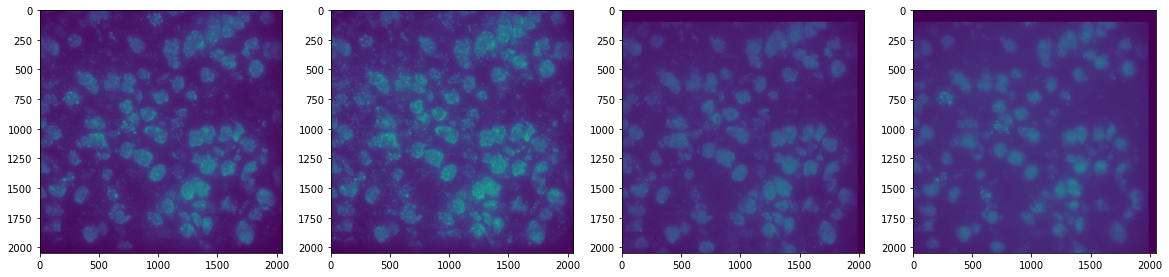

In [12]:
# Visualize a subset of images from different rounds
name_list = ['Spots 1','Spots 2','Spots 7','Spots 8']

fig,ax = plt.subplots(1,4,figsize=(20,20))
for i in range(len(name_list)):
    ax[i].imshow(aligned[name_list[i]][0,:,:,0],vmax=10000)

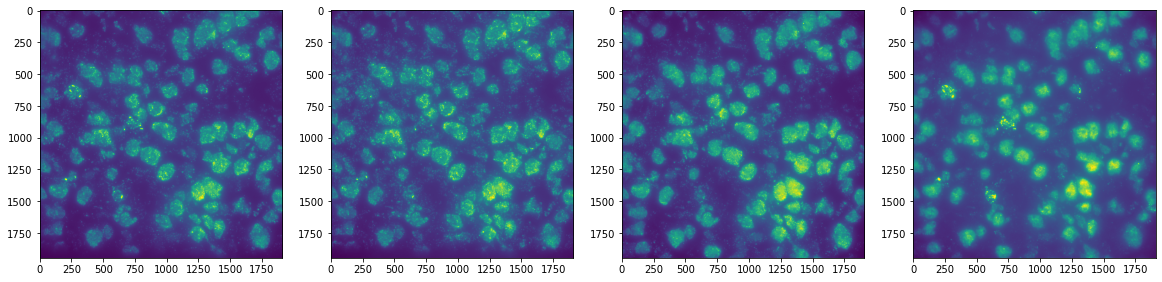

In [13]:
# Crop zero-value pixels after alignment
crop_dict = crop_images(aligned)
crop_cytoplasm_dict = crop_images(aligned_cytoplasm)

# Visualize a subset of images from different rounds
fig,ax = plt.subplots(1,4,figsize=(20,20))

for i in range(len(name_list)):
    ax[i].imshow(crop_dict[name_list[i]][0,:,:,0])

## Spot detection

In [14]:
# Instantiate the spot detection application
spots_app = SpotDetection()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: deepcell_spots.dotnet is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [15]:
# Predict spot locations
# if prediction is slow (over 5 min) try downgrading to TF 2.4
tic = time.perf_counter()
spots_app.postprocessing_fn = None

cp_dict = {}
for i,item in enumerate(crop_dict.keys()):
    if item in codebook.columns:
        cp_dict[item] = spots_app.predict(crop_dict[item][:,:,:,:])
    else:
        cp_dict[item] = np.random.random((2,1,np.shape(crop_dict[item])[1], np.shape(crop_dict[item])[2],2))*0.01

toc = time.perf_counter()
print(f"Analyzed {i} rounds in {toc - tic:0.4f} seconds")

Analyzed 11 rounds in 49.7890 seconds


## Cell segmentation

In [16]:
# Instantiate cytoplasm segmentation model
cyto_app = CytoplasmSegmentation()
cyto_app.preprocessing_fn = histogram_normalization        
cyto_app.postprocessing_fn = deep_watershed

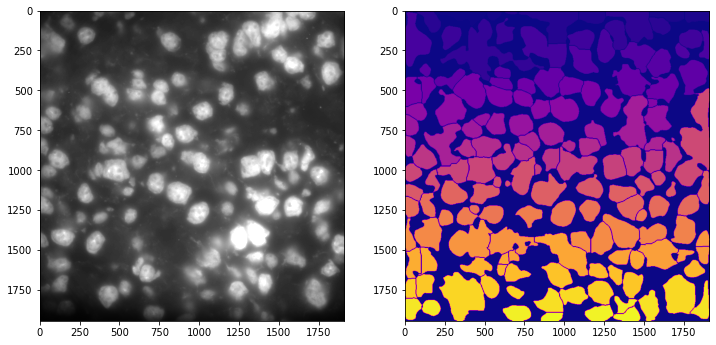

In [17]:
# Predict cytoplasm segmentation 
im = crop_cytoplasm_dict['Spots 1']
labeled_im_cyto = cyto_app.predict(im, image_mpp=0.25)

# Visualize
fig,ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].imshow(im[0,:,:,0], vmax=10000, cmap='gray')
ax[1].imshow(labeled_im_cyto[0,:,:,0], cmap='plasma')

## Assign gene barcodes

In [18]:
decoded_spots_df = assign_gene_identities(cp_dict, dataorg, threshold=0.95, codebook=codebook)
decoded_spots_df.head()

100%|██████████| 106/106 [00:00<00:00, 611.60it/s]


,Name,Code,Probability,X,Y
0,Laptm4a,18,0.563712,1944,1602
1,Blank-9,29,0.852931,1944,1414
2,background,31,0.627804,1944,382
3,Blank-4,24,0.961169,1944,368
4,background,31,0.523489,1944,339


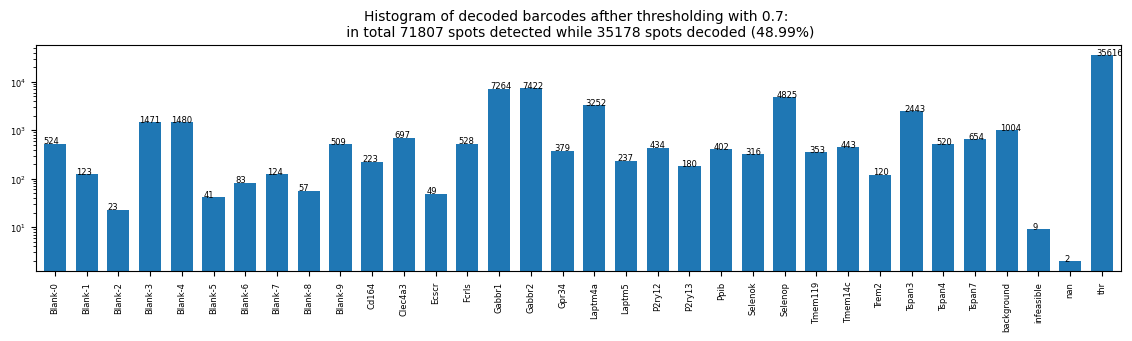

In [19]:
thr=0.7
df = pd.concat([decoded_spots_df.Name[decoded_spots_df.Probability>thr].value_counts(), decoded_spots_df.Name[decoded_spots_df.Probability <=thr].replace(np.unique(decoded_spots_df.Name),'thr').value_counts()]).sort_index(axis=0)#.sort_values(ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(14,3), dpi=100, facecolor='w', edgecolor='k')
df.plot(kind='bar',width=0.7,rot=90,logy=True,fontsize=6,ax=ax)
num_decoded_barcodes = sum((decoded_spots_df.Name!='background')&(decoded_spots_df.Name!='infeasible')&(decoded_spots_df.Name!='NaN')&(decoded_spots_df.Probability>thr))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),size=6) 
plt.title('Histogram of decoded barcodes afther thresholding with {}: \n in total {} spots detected while {} spots decoded ({:.02f}%)'.format(thr,decoded_spots_df.shape[0], num_decoded_barcodes, 100*num_decoded_barcodes/ decoded_spots_df.shape[0]),fontsize=10)       
plt.show()

## Assign spots to cells

In [20]:
output_df = assign_spots_to_cells(decoded_spots_df, labeled_im_cyto)
output_df.head()

,Name,Code,Probability,X,Y,Cell
0,Laptm4a,18,0.563712,1944,1602,0
1,Blank-9,29,0.852931,1944,1414,148
2,background,31,0.627804,1944,382,0
3,Blank-4,24,0.961169,1944,368,0
4,background,31,0.523489,1944,339,137


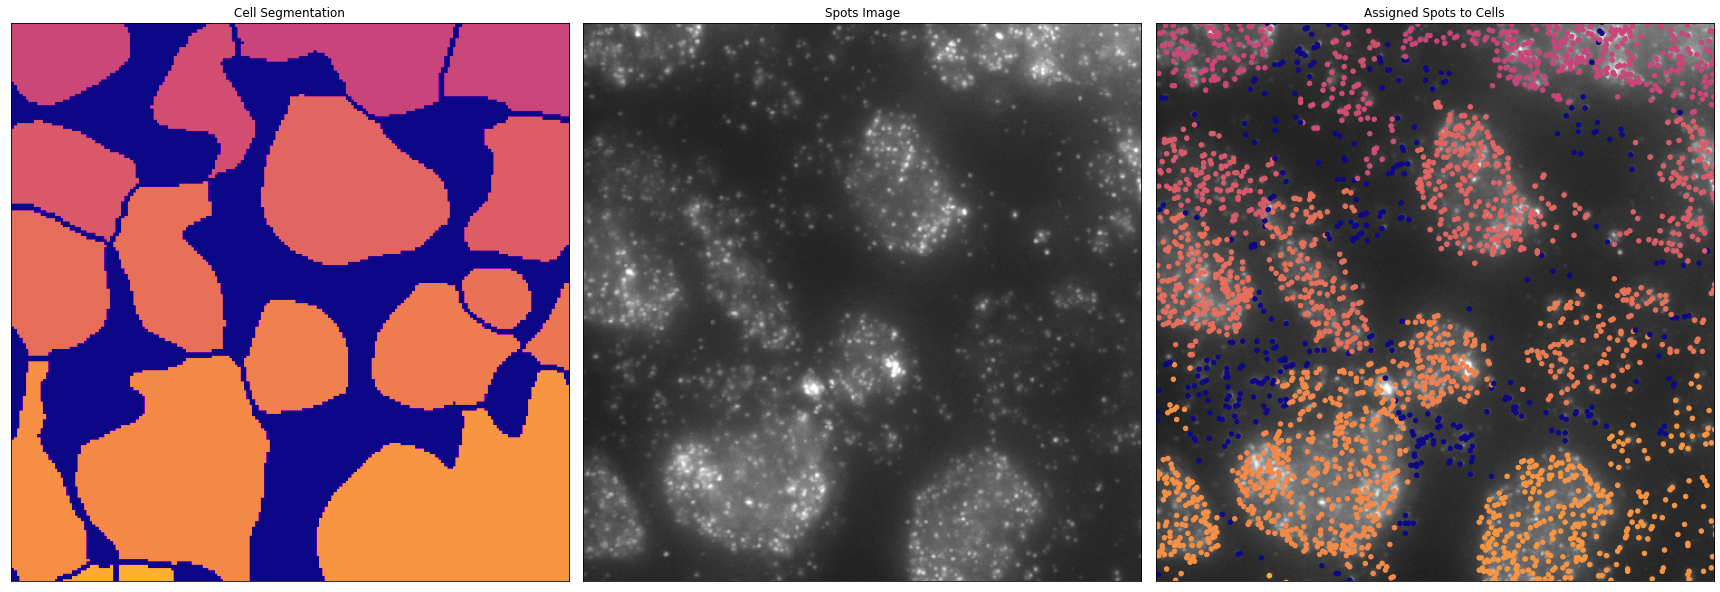

In [21]:
# Visualize
plot_threshold = 0.7

fig,ax = plt.subplots(1, 3, figsize=(24,9))
ax[0].imshow(labeled_im_cyto[0,:,:,0], cmap='plasma')
ax[0].set_title('Cell Segmentation')
ax[1].imshow(crop_dict['Spots 2'][0,:,:,0], cmap='gray')
ax[1].set_title('Spots Image')
ax[2].imshow(crop_dict['Spots 2'][0,:,:,0], cmap='gray')
ax[2].scatter(output_df.loc[output_df['Probability'] > plot_threshold]['Y'], 
            output_df.loc[output_df['Probability'] > plot_threshold]['X'],
#             facecolors='None', edgecolors='r'
              c=output_df.loc[output_df['Probability'] > plot_threshold]['Cell'], cmap='plasma', s=20
             )
ax[2].set_title('Assigned Spots to Cells')
for i in range(len(ax)):
    ax[i].set_xlim([0,500])
    ax[i].set_ylim([1500,1000])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.tight_layout()
plt.show()